In [2]:
from google.colab import files
uploaded = files.upload()


Saving staff_schedule.csv to staff_schedule.csv
Saving services_weekly.csv to services_weekly.csv
Saving patients.csv to patients.csv


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [4]:
patients = pd.read_csv('patients.csv', parse_dates = ['arrival_date', 'departure_date'])
staff = pd.read_csv('staff_schedule.csv')
services = pd.read_csv('services_weekly.csv')


In [5]:
print("Patients")
patients['length_of_stay'] = (patients['departure_date'] - patients['arrival_date']).dt.days + 1
patients['week'] = patients['arrival_date'].dt.isocalendar().week.astype(int)

print(f"Shape: {patients.shape}")
print(f"Columns: {patients.columns}")
print(f"Data Types: {patients.dtypes}")
patients.head()

Patients
Shape: (1000, 9)
Columns: Index(['patient_id', 'name', 'age', 'arrival_date', 'departure_date',
       'service', 'satisfaction', 'length_of_stay', 'week'],
      dtype='object')
Data Types: patient_id                object
name                      object
age                        int64
arrival_date      datetime64[ns]
departure_date    datetime64[ns]
service                   object
satisfaction               int64
length_of_stay             int64
week                       int64
dtype: object


,patient_id,name,age,arrival_date,departure_date,service,satisfaction,length_of_stay,week
0,PAT-09484753,Richard Rodriguez,24,2025-03-16,2025-03-22,surgery,61,7,11
1,PAT-f0644084,Shannon Walker,6,2025-12-13,2025-12-14,surgery,83,2,50
2,PAT-ac6162e4,Julia Torres,24,2025-06-29,2025-07-05,general_medicine,83,7,26
3,PAT-3dda2bb5,Crystal Johnson,32,2025-10-12,2025-10-23,emergency,81,12,41
4,PAT-08591375,Garrett Lin,25,2025-02-18,2025-02-25,ICU,76,8,8


In [6]:
patients_agg = patients.groupby(['week', 'service']).agg(
    new_patients=('patient_id', 'count'),
    avg_age=('age', 'mean'),
    avg_los=('length_of_stay', 'mean'),
    avg_satisfaction=('satisfaction', 'mean')
    ).reset_index()

patients_agg.head()


,week,service,new_patients,avg_age,avg_los,avg_satisfaction
0,1,ICU,7,43.00,6.428571,84.857143
1,1,emergency,4,42.25,10.250000,86.000000
2,1,general_medicine,5,51.20,8.400000,77.400000
3,1,surgery,6,50.00,11.000000,84.666667
4,2,ICU,4,50.75,9.000000,69.250000


In [7]:
print("Staff")
print(f"Shape: {staff.shape}")
print(f"Columns: {staff.columns}")
print(f"Data Types: {staff.dtypes}")
staff.head()

Staff
Shape: (6552, 6)
Columns: Index(['week', 'staff_id', 'staff_name', 'role', 'service', 'present'], dtype='object')
Data Types: week           int64
staff_id      object
staff_name    object
role          object
service       object
present        int64
dtype: object


,week,staff_id,staff_name,role,service,present
0,1,STF-b77cdc60,Allison Hill,doctor,emergency,1
1,2,STF-b77cdc60,Allison Hill,doctor,emergency,1
2,3,STF-b77cdc60,Allison Hill,doctor,emergency,0
3,4,STF-b77cdc60,Allison Hill,doctor,emergency,1
4,5,STF-b77cdc60,Allison Hill,doctor,emergency,1


In [8]:
staff_agg = staff.groupby(['week', 'service']).agg(
    staff_present=('present', 'sum'),
    staff_count=('staff_id', 'nunique')
    ).reset_index()

staff_agg.head()

,week,service,staff_present,staff_count
0,1,ICU,31,34
1,1,emergency,35,39
2,1,general_medicine,27,28
3,1,surgery,23,25
4,2,ICU,30,34


In [9]:
print("Services")
services['occupancy_rate'] = services['patients_admitted'] / services['available_beds']
services['occupancy_rate'] = services['occupancy_rate'].clip(0, 1)
print(f"Shape: {services.shape}")
print(f"Columns: {services.columns}")
print(f"Data Types: {services.dtypes}")
services.head()

Services
Shape: (208, 11)
Columns: Index(['week', 'month', 'service', 'available_beds', 'patients_request',
       'patients_admitted', 'patients_refused', 'patient_satisfaction',
       'staff_morale', 'event', 'occupancy_rate'],
      dtype='object')
Data Types: week                      int64
month                     int64
service                  object
available_beds            int64
patients_request          int64
patients_admitted         int64
patients_refused          int64
patient_satisfaction      int64
staff_morale              int64
event                    object
occupancy_rate          float64
dtype: object


,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event,occupancy_rate
0,1,1,emergency,32,76,32,44,67,70,none,1.0
1,1,1,surgery,45,130,45,85,83,78,flu,1.0
2,1,1,general_medicine,37,201,37,164,97,43,flu,1.0
3,1,1,ICU,22,31,22,9,84,91,flu,1.0
4,2,1,emergency,28,169,28,141,75,64,none,1.0


In [10]:
merged = services.merge(patients_agg, on=['week', 'service'], how='left') \
                 .merge(staff_agg, on=['week', 'service'], how='left')

print(merged.dtypes)
merged.head()

week                      int64
month                     int64
service                  object
available_beds            int64
patients_request          int64
patients_admitted         int64
patients_refused          int64
patient_satisfaction      int64
staff_morale              int64
event                    object
occupancy_rate          float64
new_patients              int64
avg_age                 float64
avg_los                 float64
avg_satisfaction        float64
staff_present             int64
staff_count               int64
dtype: object


,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event,occupancy_rate,new_patients,avg_age,avg_los,avg_satisfaction,staff_present,staff_count
0,1,1,emergency,32,76,32,44,67,70,none,1.0,4,42.250000,10.250000,86.000000,35,39
1,1,1,surgery,45,130,45,85,83,78,flu,1.0,6,50.000000,11.000000,84.666667,23,25
2,1,1,general_medicine,37,201,37,164,97,43,flu,1.0,5,51.200000,8.400000,77.400000,27,28
3,1,1,ICU,22,31,22,9,84,91,flu,1.0,7,43.000000,6.428571,84.857143,31,34
4,2,1,emergency,28,169,28,141,75,64,none,1.0,3,58.333333,7.000000,74.000000,37,39


In [11]:
merged[['new_patients', 'avg_age', 'avg_los', 'avg_satisfaction',
            'staff_present', 'staff_count']] = merged[[
            'new_patients', 'avg_age', 'avg_los',
            'avg_satisfaction', 'staff_present', 'staff_count'
            ]].fillna(0)

merged.to_csv("cleaned_hospital_dataset.csv", index=False)

=== BASIC INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   week                  208 non-null    int64  
 1   month                 208 non-null    int64  
 2   service               208 non-null    object 
 3   available_beds        208 non-null    int64  
 4   patients_request      208 non-null    int64  
 5   patients_admitted     208 non-null    int64  
 6   patients_refused      208 non-null    int64  
 7   patient_satisfaction  208 non-null    int64  
 8   staff_morale          208 non-null    int64  
 9   event                 208 non-null    object 
 10  occupancy_rate        208 non-null    float64
 11  new_patients          208 non-null    int64  
 12  avg_age               208 non-null    float64
 13  avg_los               208 non-null    float64
 14  avg_satisfaction      208 non-null    float64
 15  staf

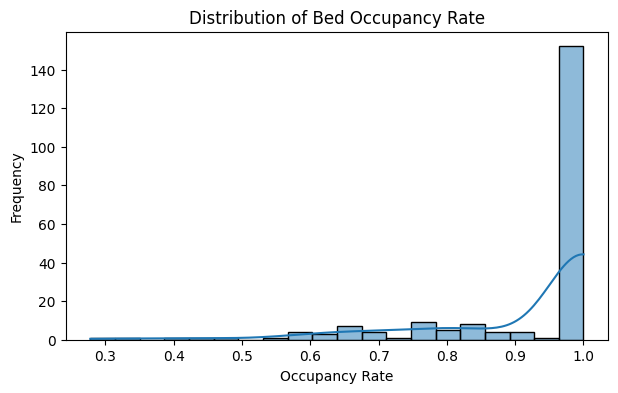

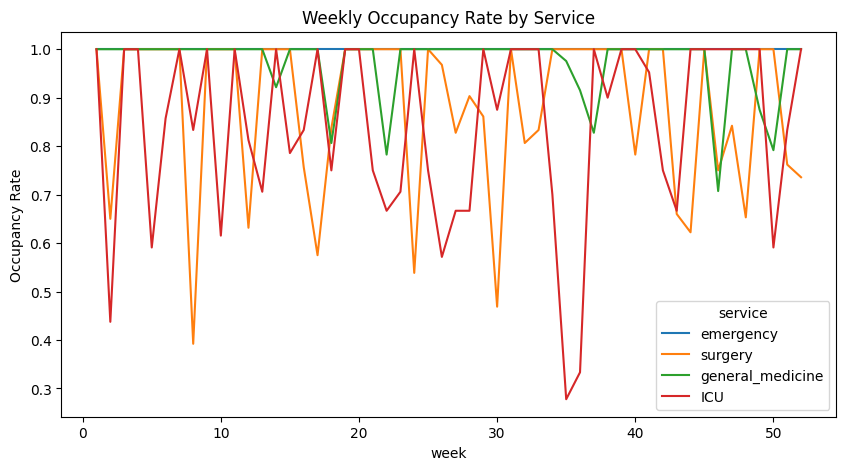

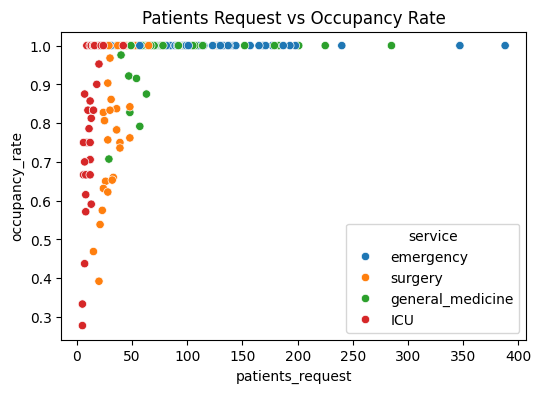

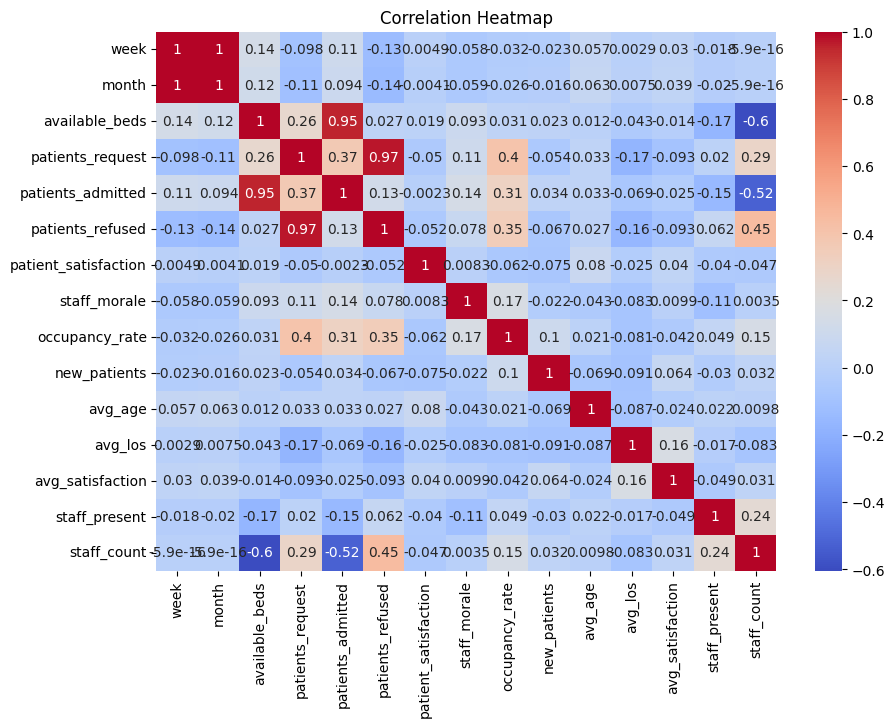

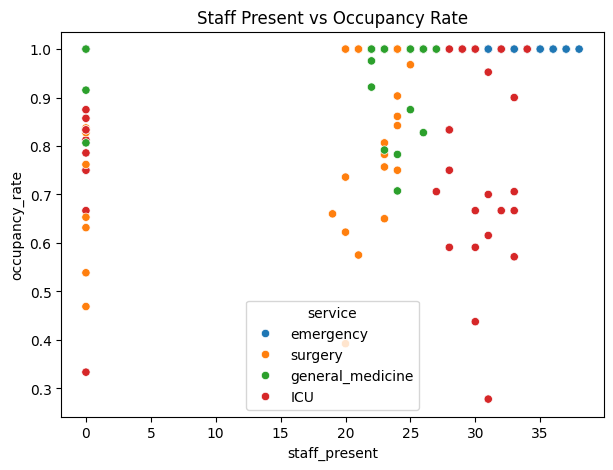


Weeks with >95% occupancy:

     week           service  occupancy_rate  patients_request  \
0       1         emergency             1.0                76   
1       1           surgery             1.0               130   
2       1  general_medicine             1.0               201   
3       1               ICU             1.0                31   
4       2         emergency             1.0               169   
..    ...               ...             ...               ...   
200    51         emergency             1.0               123   
202    51  general_medicine             1.0               285   
204    52         emergency             1.0               130   
206    52  general_medicine             1.0               225   
207    52               ICU             1.0                24   

     patients_admitted  
0                   32  
1                   45  
2                   37  
3                   22  
4                   28  
..                 ...  
200            

In [31]:
# Exploratory Data Analysis

print("=== BASIC INFO ===")
print(merged.info())
print("\nMissing values:\n", merged.isna().sum())

plt.figure(figsize=(7,4))
sns.histplot(merged['occupancy_rate'], bins=20, kde=True)
plt.title("Distribution of Bed Occupancy Rate")
plt.xlabel("Occupancy Rate")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=merged, x="week", y="occupancy_rate", hue="service")
plt.title("Weekly Occupancy Rate by Service")
plt.ylabel("Occupancy Rate")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=merged, x="patients_request", y="occupancy_rate", hue="service")
plt.title("Patients Request vs Occupancy Rate")
plt.show()

numeric_cols = merged.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,7))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data=merged, x='staff_present', y='occupancy_rate', hue="service")
plt.title("Staff Present vs Occupancy Rate")
plt.show()

high_occ = merged[merged['occupancy_rate'] > 0.95]
print("\nWeeks with >95% occupancy:\n")
print(high_occ[['week', 'service', 'occupancy_rate', 'patients_request', 'patients_admitted']])


In [14]:
df = merged.copy()

df['ICU_demand_level'] = df.apply(lambda row:
    ('high' if row['service'] == 'ICU' and row['occupancy_rate'] >= 0.95 else
     'moderate' if row['service'] == 'ICU' and row['occupancy_rate'] >= 0.80 else
     'low' if row['service'] == 'ICU' else None),
    axis=1
)

def shortage_level(row):
    ratio = row['staff_present'] / row['staff_count']
    if ratio >= 0.9: return 'low'
    elif ratio >= 0.7: return 'moderate'
    else: return 'high'

df['staff_shortage_level'] = df.apply(shortage_level, axis=1)

print(df.dtypes)
df.head()

week                      int64
month                     int64
service                  object
available_beds            int64
patients_request          int64
patients_admitted         int64
patients_refused          int64
patient_satisfaction      int64
staff_morale              int64
event                    object
occupancy_rate          float64
new_patients              int64
avg_age                 float64
avg_los                 float64
avg_satisfaction        float64
staff_present             int64
staff_count               int64
ICU_demand_level         object
staff_shortage_level     object
dtype: object


,week,month,service,available_beds,patients_request,patients_admitted,patients_refused,patient_satisfaction,staff_morale,event,occupancy_rate,new_patients,avg_age,avg_los,avg_satisfaction,staff_present,staff_count,ICU_demand_level,staff_shortage_level
0,1,1,emergency,32,76,32,44,67,70,none,1.0,4,42.250000,10.250000,86.000000,35,39,None,moderate
1,1,1,surgery,45,130,45,85,83,78,flu,1.0,6,50.000000,11.000000,84.666667,23,25,None,low
2,1,1,general_medicine,37,201,37,164,97,43,flu,1.0,5,51.200000,8.400000,77.400000,27,28,None,low
3,1,1,ICU,22,31,22,9,84,91,flu,1.0,7,43.000000,6.428571,84.857143,31,34,high,low
4,2,1,emergency,28,169,28,141,75,64,none,1.0,3,58.333333,7.000000,74.000000,37,39,None,low


In [15]:
#Bed Occupancy Rate

In [32]:
bor_df = df.copy()


cat_cols = bor_df.select_dtypes(include=['object']).columns
print("Categorical columns:", cat_cols)

bor_df = pd.get_dummies(bor_df, columns=cat_cols, drop_first=False)

x_bor = bor_df.drop(columns=['occupancy_rate'])
y_bor = bor_df['occupancy_rate']

print("X shape:", x_bor.shape)
print("Y shape:", y_bor.shape)
print("\nX columns:", x_bor.columns)



Categorical columns: Index(['service', 'event', 'ICU_demand_level', 'staff_shortage_level'], dtype='object')
X shape: (208, 28)
Y shape: (208,)

X columns: Index(['week', 'month', 'available_beds', 'patients_request',
       'patients_admitted', 'patients_refused', 'patient_satisfaction',
       'staff_morale', 'new_patients', 'avg_age', 'avg_los',
       'avg_satisfaction', 'staff_present', 'staff_count', 'service_ICU',
       'service_emergency', 'service_general_medicine', 'service_surgery',
       'event_donation', 'event_flu', 'event_none', 'event_strike',
       'ICU_demand_level_high', 'ICU_demand_level_low',
       'ICU_demand_level_moderate', 'staff_shortage_level_high',
       'staff_shortage_level_low', 'staff_shortage_level_moderate'],
      dtype='object')


In [33]:
#test
x_bor_train, x_bor_test, y_bor_train, y_bor_test = train_test_split(
    x_bor, y_bor, test_size=0.2, random_state=42
)

scaler = StandardScaler()
x_bor_train_scaled = scaler.fit_transform(x_bor_train)
x_bor_test_scaled = scaler.transform(x_bor_test)

In [34]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

model.fit(x_bor_train_scaled, y_bor_train)


RandomForestRegressor(n_estimators=300, random_state=42)

In [35]:
y_bor_pred = model.predict(x_bor_test_scaled)

mae = mean_absolute_error(y_bor_test, y_bor_pred)
rmse = np.sqrt(mean_squared_error(y_bor_test, y_bor_pred))
r2 = r2_score(y_bor_test, y_bor_pred)

print("Model Performance:")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²   :", r2)

Model Performance:
MAE : 0.027707236732830005
RMSE: 0.06302038730908993
R²   : 0.6990046902758629


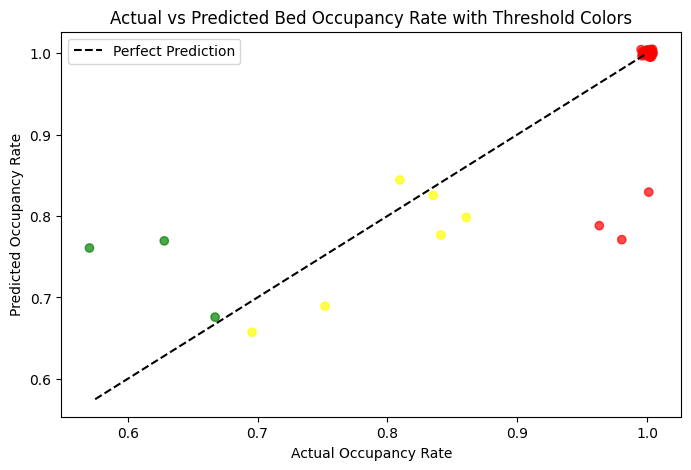

'\nhow to implement\nif predicted_occupancy >= 0.95:\n    alert = "RED: Capacity critical!"\nelif predicted_occupancy >= 0.7:\n    alert = "YELLOW: High occupancy"\nelse:\n    alert = "GREEN: Safe occupancy"\n'

In [21]:
jitter = 0.005
x_jittered = y_bor_test + np.random.uniform(-jitter, jitter, size=len(y_bor_test))
y_jittered = y_bor_pred + np.random.uniform(-jitter, jitter, size=len(y_bor_pred))

colors = []
for val in y_bor_test:
    if val >= 0.95:
        colors.append('red')
    elif val >= 0.7:
        colors.append('yellow')
    else:
        colors.append('green')

plt.figure(figsize=(8,5))
plt.scatter(x_jittered, y_jittered, c=colors, alpha=0.7)
plt.plot([y_bor_test.min(), y_bor_test.max()], [y_bor_test.min(), y_bor_test.max()], linestyle='--', color='black', label='Perfect Prediction')
plt.xlabel("Actual Occupancy Rate")
plt.ylabel("Predicted Occupancy Rate")
plt.title("Actual vs Predicted Bed Occupancy Rate with Threshold Colors")
plt.legend()
plt.show()

"""
how to implement
if predicted_occupancy >= 0.95:
    alert = "RED: Capacity critical!"
elif predicted_occupancy >= 0.7:
    alert = "YELLOW: High occupancy"
else:
    alert = "GREEN: Safe occupancy"
"""



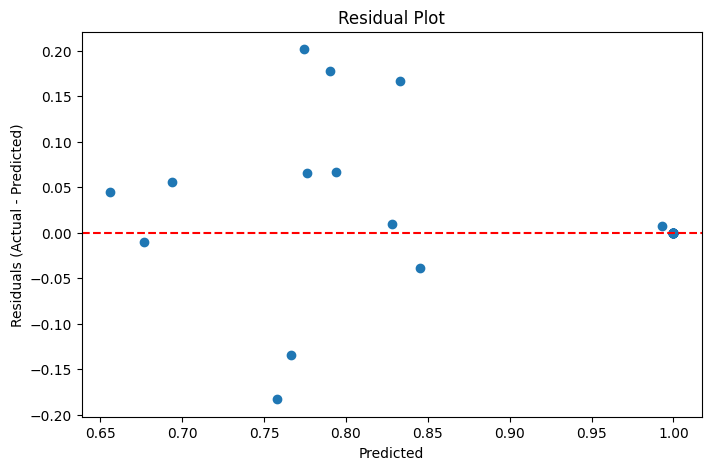

In [22]:
residuals = y_bor_test - y_bor_pred

plt.figure(figsize=(8,5))
plt.scatter(y_bor_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()


In [23]:
#ICU Demand Random Forest

In [24]:
icu_df = df.copy()

icu_df = df[df['service'] == 'ICU'].copy()
icu_df = icu_df.drop(columns=['service'])

cat_cols = icu_df.select_dtypes(include=['object']).columns.tolist()
if 'ICU_demand_level' in cat_cols:
    cat_cols.remove('ICU_demand_level')
icu_df = pd.get_dummies(icu_df, columns=cat_cols, drop_first=False)


X_icu = icu_df.drop(columns=['ICU_demand_level'])
y_icu = icu_df['ICU_demand_level']

X_icu_train, X_icu_test, y_icu_train, y_icu_test = train_test_split(
    X_icu, y_icu, test_size=0.2, random_state=42, stratify=y_icu
)

icu_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
icu_model.fit(X_icu_train, y_icu_train)

y_icu_pred = icu_model.predict(X_icu_test)
print("=== ICU Model Performance ===")
print("Accuracy:", accuracy_score(y_icu_test, y_icu_pred))
print("Confusion Matrix:\n", confusion_matrix(y_icu_test, y_icu_pred))
print("Classification Report:\n", classification_report(y_icu_test, y_icu_pred))

new_icu_data = icu_df.drop(columns=['ICU_demand_level']).head(5)

new_icu_data_encoded = pd.get_dummies(new_icu_data)

for col in X_icu.columns:
    if col not in new_icu_data_encoded:
        new_icu_data_encoded[col] = 0

new_icu_data_encoded = new_icu_data_encoded[X_icu.columns]

new_icu_data['ICU_demand_level'] = icu_model.predict(new_icu_data_encoded)

alert_map = {'low': 'Green', 'moderate': 'Yellow', 'high': 'Red'}
new_icu_data['ICU_demand_alert'] = new_icu_data['ICU_demand_level'].map(alert_map)

print("\n=== ICU Alerts for New Data ===")
print(new_icu_data[['occupancy_rate', 'ICU_demand_level', 'ICU_demand_alert']])



=== ICU Model Performance ===
Accuracy: 0.8181818181818182
Confusion Matrix:
 [[5 1 0]
 [0 4 0]
 [0 1 0]]
Classification Report:
               precision    recall  f1-score   support

        high       1.00      0.83      0.91         6
         low       0.67      1.00      0.80         4
    moderate       0.00      0.00      0.00         1

    accuracy                           0.82        11
   macro avg       0.56      0.61      0.57        11
weighted avg       0.79      0.82      0.79        11


=== ICU Alerts for New Data ===
    occupancy_rate ICU_demand_level ICU_demand_alert
3         1.000000             high              Red
7         0.437500              low            Green
11        1.000000             high              Red
15        1.000000             high              Red
19        0.590909              low            Green


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
#Staff Shortage Prediction

In [26]:
staff_df = df.copy()

cat_cols_staff = staff_df.select_dtypes(include=['object']).columns.tolist()
if 'staff_shortage_level' in cat_cols_staff:
    cat_cols_staff.remove('staff_shortage_level')

staff_df = pd.get_dummies(staff_df, columns=cat_cols_staff, drop_first=False)

X_staff = staff_df.drop(columns=['staff_shortage_level'])
y_staff = staff_df['staff_shortage_level']

X_staff_train, X_staff_test, y_staff_train, y_staff_test = train_test_split(
    X_staff, y_staff, test_size=0.2, random_state=42, stratify=y_staff
)

staff_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)
staff_model.fit(X_staff_train, y_staff_train)

y_staff_pred = staff_model.predict(X_staff_test)

print("=== STAFF SHORTAGE MODEL PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_staff_test, y_staff_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_staff_test, y_staff_pred))
print("\nClassification Report:\n", classification_report(y_staff_test, y_staff_pred))



=== STAFF SHORTAGE MODEL PERFORMANCE ===
Accuracy: 0.7619047619047619

Confusion Matrix:
 [[14  0  0]
 [ 0  8  6]
 [ 0  4 10]]

Classification Report:
               precision    recall  f1-score   support

        high       1.00      1.00      1.00        14
         low       0.67      0.57      0.62        14
    moderate       0.62      0.71      0.67        14

    accuracy                           0.76        42
   macro avg       0.76      0.76      0.76        42
weighted avg       0.76      0.76      0.76        42


=== SAMPLE STAFF SHORTAGE PREDICTIONS ===
   staff_present  staff_count staff_shortage_level predicted_shortage  \
0             35           39             moderate           moderate   
1             23           25                  low                low   
2             27           28                  low                low   
3             31           34                  low                low   
4             37           39                  low         